In [1]:
import nemo
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
from omegaconf import DictConfig
import pathlib
import nemo.collections.asr as nemo_asr
import pytorch_lightning as pl
import os
import matplotlib.pyplot as plt
import re

import copy
import json
import os
import tempfile
from math import ceil
from typing import Dict, List, Optional, Union

import torch
from omegaconf import DictConfig, OmegaConf, open_dict
from pytorch_lightning import Trainer
from torch.utils.data import ChainDataset
from tqdm.auto import tqdm

from nemo.collections.asr.data import audio_to_text_dataset
from nemo.collections.asr.data.audio_to_text_dali import DALIOutputs
from nemo.collections.asr.losses.ctc import CTCLoss
from nemo.collections.asr.metrics.wer import WER
from nemo.collections.asr.models.asr_model import ASRModel, ExportableEncDecModel
from nemo.collections.asr.parts.mixins import ASRModuleMixin
from nemo.collections.asr.parts.preprocessing.perturb import process_augmentations
from nemo.core.classes.common import PretrainedModelInfo, typecheck
from nemo.core.neural_types import AudioSignal, LabelsType, LengthsType, LogprobsType, NeuralType, SpectrogramType
from nemo.utils import logging
from nemo.collections.tts.models import FastPitchHifiGanE2EModel

import IPython.display as ipd
import librosa
import librosa.display
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

# Reduce logging messages for this notebook
from nemo.utils import logging
logging.setLevel(logging.ERROR)

from nemo.collections.tts.models import FastPitchModel
from nemo.collections.tts.models import HifiGanModel
from nemo.collections.tts.helpers.helpers import regulate_len
from nemo.collections.tts.models import MelGanModel

import torch.nn.functional as F
from matplotlib.pyplot import imshow

from nemo.collections.tts.models import FastPitchModel
import pytorch_lightning as pl

from nemo.collections.common.callbacks import LogEpochTimeCallback
from nemo.collections.tts.models import FastPitchModel
from nemo.core.config import hydra_runner
from nemo.utils import logging
from nemo.utils.exp_manager import exp_manager
import noisereduce as nr


try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML

from dataset import UnpairedAudioToBPEDataset

[NeMo W 2022-02-07 01:51:20 optimizers:47] Apex was not found. Using the lamb optimizer will error out.
[NeMo W 2022-02-07 01:51:20 nemo_logging:349] /home/boris/anaconda3/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    
[NeMo W 2022-02-07 01:51:20 nmse_clustering:54] Using eigen decomposition from scipy, upgrade torch to 1.9 or higher for faster clustering
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################

[NeMo W 2022-02-07 01:51:20 nemo_logging:34

In [80]:
trainer = pl.Trainer(max_epochs=1,
                     gpus=1,
                     checkpoint_callback=False,
#                      logger=False,
                     gradient_clip_val=1000.0,
                     flush_logs_every_n_steps=1000,
                     log_every_n_steps=100,
                     check_val_every_n_epoch=3, 
                    )

exp_manager(trainer, DictConfig(config).get("exp_manager", None))

lr_logger = pl.callbacks.LearningRateMonitor()
epoch_time_logger = LogEpochTimeCallback()
trainer.callbacks.extend([lr_logger, epoch_time_logger])
# trainer.fit(asr_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


InterpolationKeyError: Interpolation key 'name' not found
    full_key: exp_manager.name
    object_type=dict

In [31]:
def training_step(model, batch, batch_nb):
    signal, signal_len, transcript, transcript_len = batch
    if isinstance(batch, DALIOutputs) and batch.has_processed_signal:
        log_probs, encoded_len, predictions = model.forward(
            processed_signal=signal, processed_signal_length=signal_len
        )
    else:
        log_probs, encoded_len, predictions = model.forward(input_signal=signal, input_signal_length=signal_len)

    loss_value = model.loss(
        log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
    )

#     tensorboard_logs = {'train_loss': loss_value, 'learning_rate': self._optimizer.param_groups[0]['lr']}

#     if hasattr(model, '_trainer') and model._trainer is not None:
#         log_every_n_steps = self._trainer.log_every_n_steps
#     else:
#         log_every_n_steps = 1

#     if (batch_nb + 1) % log_every_n_steps == 0:
#         self._wer.update(
#             predictions=predictions,
#             targets=transcript,
#             target_lengths=transcript_len,
#             predictions_lengths=encoded_len,
#         )
#         wer, _, _ = self._wer.compute()
#         self._wer.reset()
#         tensorboard_logs.update({'training_batch_wer': wer})

    return {'loss': loss_value} #, 'log': tensorboard_logs}

In [8]:
def tts_training_step(batch, batch_idx):
        
    spec_gen.on_train_batch_start(batch, batch_idx, dataloader_idx)

    spec_gen.on_before_batch_transfer(batch, dataloader_idx)
    spec_gen.transfer_batch_to_device(batch, torch.device("cuda"), dataloader_idx)
    spec_gen.on_after_batch_transfer(batch, dataloader_idx)

    # |-------------------------------------------------------------|

    attn_prior, durs, speaker = None, None, None
    audio, audio_lens, text, text_lens, attn_prior, pitch, speaker = batch

    mels, spec_len = spec_gen.preprocessor(input_signal=audio, length=audio_lens)

    mels_pred, _, _, log_durs_pred, pitch_pred, attn_soft, attn_logprob, attn_hard, attn_hard_dur, pitch = spec_gen(
        text=text,
        durs=durs,
        pitch=pitch,
        speaker=speaker,
        pace=1.0,
        spec=mels,
        attn_prior=attn_prior,
        mel_lens=spec_len,
        input_lens=text_lens,
    )
    if durs is None:
        durs = attn_hard_dur

    mel_loss = spec_gen.mel_loss(spect_predicted=mels_pred, spect_tgt=mels)
    dur_loss = spec_gen.duration_loss(log_durs_predicted=log_durs_pred, durs_tgt=durs, len=text_lens)
    loss = mel_loss + dur_loss
#         if self.learn_alignment:
    ctc_loss = spec_gen.forward_sum_loss(attn_logprob=attn_logprob, in_lens=text_lens, out_lens=spec_len)
    bin_loss_weight = min(spec_gen.current_epoch / spec_gen.bin_loss_warmup_epochs, 1.0) * 1.0
    bin_loss = spec_gen.bin_loss(hard_attention=attn_hard, soft_attention=attn_soft) * bin_loss_weight
    loss += ctc_loss + bin_loss

    pitch_loss = spec_gen.pitch_loss(pitch_predicted=pitch_pred, pitch_tgt=pitch, len=text_lens)
    loss += pitch_loss

    # |-------------------------------------------------------------|

    spec_gen.on_before_zero_grad(spec_gen._optimizer)
    spec_gen.optimizer_zero_grad(epoch, batch_idx, spec_gen._optimizer, batch_idx)

    spec_gen.on_before_backward(loss)
    spec_gen.backward(loss, spec_gen._optimizer, batch_idx)
    spec_gen.on_after_backward()

    spec_gen.on_before_optimizer_step(spec_gen._optimizer, batch_idx)
    spec_gen.optimizer_step(epoch, batch_idx, spec_gen._optimizer, batch_idx)

    spec_gen.on_train_batch_end(mels_pred, batch, batch_idx, dataloader_idx)

    # |-------------------------------------------------------------|

    batch = [audio, audio_lens, mels_pred]

    vocoder.on_train_batch_start(batch, batch_idx, dataloader_idx)

#         vocoder.on_before_batch_transfer(batch, dataloader_idx)
#         vocoder.transfer_batch_to_device(batch, torch.device("cuda"), dataloader_idx)
#         vocoder.on_after_batch_transfer(batch, dataloader_idx)

    # |-------------------------------------------------------------|

    audio, audio_len, audio_mel = batch

    # Mel as input for L1 mel loss
    audio_trg_mel, _ = vocoder.trg_melspec_fn(audio, audio_len)
    audio = audio.unsqueeze(1)

    audio_pred = vocoder.generator(x=audio_mel)
    audio_pred_mel, _ = vocoder.trg_melspec_fn(audio_pred.squeeze(1), audio_len)

    optim_g, optim_d = vocoder.optim_g, vocoder.optim_g

    # Train discriminator
    vocoder.on_before_zero_grad(optim_d)
    vocoder.optimizer_zero_grad(epoch, batch_idx, optim_d, batch_idx)

    mpd_score_real, mpd_score_gen, _, _ = vocoder.mpd(y=audio, y_hat=audio_pred.detach())
    loss_disc_mpd, _, _ = vocoder.discriminator_loss(
        disc_real_outputs=mpd_score_real, disc_generated_outputs=mpd_score_gen
    )
    msd_score_real, msd_score_gen, _, _ = vocoder.msd(y=audio, y_hat=audio_pred.detach())
    loss_disc_msd, _, _ = vocoder.discriminator_loss(
        disc_real_outputs=msd_score_real, disc_generated_outputs=msd_score_gen
    )
    loss_d = loss_disc_msd + loss_disc_mpd
#         spec_gen.backward(loss_d, optim_g, 0)
#         optim_d.step()

    # |-------------------------------------------------------------|

    vocoder.on_before_backward(loss_d)
    vocoder.backward(loss_d, optim_d, 0)
    vocoder.on_after_backward()

    vocoder.on_before_optimizer_step(optim_d, batch_idx)
    vocoder.optimizer_step(epoch, batch_idx, optim_d, 0)

    # |-------------------------------------------------------------|


#         # Train generator
#         spec_gen.on_before_zero_grad(optim_g)
#         spec_gen.optimizer_zero_grad(epoch, batch_idx, optim_g, batch_idx)

#         loss_mel = F.l1_loss(audio_pred_mel, audio_trg_mel)
#         _, mpd_score_gen, fmap_mpd_real, fmap_mpd_gen = vocoder.mpd(y=audio, y_hat=audio_pred)
#         _, msd_score_gen, fmap_msd_real, fmap_msd_gen = vocoder.msd(y=audio, y_hat=audio_pred)
#         loss_fm_mpd = vocoder.feature_loss(fmap_r=fmap_mpd_real, fmap_g=fmap_mpd_gen)
#         loss_fm_msd = vocoder.feature_loss(fmap_r=fmap_msd_real, fmap_g=fmap_msd_gen)
#         loss_gen_mpd, _ = vocoder.generator_loss(disc_outputs=mpd_score_gen)
#         loss_gen_msd, _ = vocoder.generator_loss(disc_outputs=msd_score_gen)
#         loss_g = loss_gen_msd + loss_gen_mpd + loss_fm_msd + loss_fm_mpd + loss_mel * vocoder.l1_factor

#         spec_gen.on_before_backward(loss_g)
#         spec_gen.backward(loss_g, optim_g, 0)
#         spec_gen.on_after_backward()

#         spec_gen.on_before_optimizer_step(optim_g, batch_idx)
#         spec_gen.optimizer_step(epoch, batch_idx, optim_g, 0)

#         # Run schedulers
    schedulers = vocoder.lr_schedulers()
    if schedulers is not None:
        sch1, sch2 = schedulers
        sch1.step()
        sch2.step()
    vocoder.on_train_batch_end(audio_pred, batch, batch_idx, dataloader_idx)

    # |-------------------------------------------------------------|

    return loss.cpu().detach().numpy(), loss_d.cpu().detach().numpy()

In [6]:
spec_gen.parse('qwe')

tensor([[ 0, 86, 92, 74, 98,  0]], device='cuda:0')

In [11]:
asr_model.tokenizer.text_to_ids('with the reduction of numbers to be accommodated, there was ample space in newgate for its reconstruction on the most approved modern lines.')

[48,
 2,
 47,
 10,
 56,
 345,
 12,
 664,
 1,
 8,
 23,
 514,
 303,
 346,
 10,
 284,
 0,
 70,
 24,
 553,
 30,
 55,
 914,
 14,
 215,
 34,
 148,
 27,
 15,
 1,
 47,
 40,
 101,
 1,
 3,
 272,
 345,
 44,
 2,
 315,
 378,
 147,
 68,
 10,
 819,
 22,
 18,
 697,
 1,
 0]

In [10]:
for batch in asr_model.train_dataloader():
    print(batch)
    break

[tensor([[ 0.0002,  0.0002,  0.0003,  ..., -0.0003, -0.0007, -0.0008]]), tensor([186013]), tensor([[ 48,   2,  47,  10,  56, 345,  12, 664,   1,   8,  23, 514, 303, 346,
          10, 284,   0,  70,  24, 553,  30,  55, 914,  14, 215,  34, 148,  27,
          15,   1,  47,  40, 101,   1,   3, 272, 345,  44,   2, 315, 378, 147,
          68,  10, 819,  22,  18, 697,   1,   0]]), tensor([50])]


In [9]:
on_train_start()

dataloader_idx = 0
for epoch in range(5):
    loss_avg = []
    loss_d_avg = []
    for batch_idx, batch in enumerate(spec_gen.train_dataloader()):
        signal, signal_len, transcript, transcript_len, attn_prior, pitch, speaker = batch
        signal, signal_len, transcript, transcript_len, attn_prior, pitch = \
            signal.cuda(), signal_len.cuda(), \
            transcript.cuda(), transcript_len.cuda(), attn_prior.cuda(), pitch.cuda()
        batch = [signal, signal_len, transcript, transcript_len, attn_prior, pitch, speaker]
        
        loss, loss_d = tts_training_step(batch, batch_idx)
        loss_avg.append(loss)
        loss_d_avg.append(loss_d)
#         print(loss_value)
    print(epoch, np.mean(loss_avg), np.mean(loss_d_avg))

0 2.664061 4.1731133
1 2.3329694 4.1397004
2 2.1727934 4.1421585


KeyboardInterrupt: 

In [2]:
def hifigan_training_step(self, batch, batch_idx):
        if self.input_as_mel:
            # Pre-computed spectrograms will be used as input
            audio, audio_len, audio_mel = batch
        else:
            audio, audio_len = batch
            audio_mel, _ = self.audio_to_melspec_precessor(audio, audio_len)

        # Mel as input for L1 mel loss
        audio_trg_mel, _ = self.trg_melspec_fn(audio, audio_len)
        audio = audio.unsqueeze(1)

        audio_pred = self.generator(x=audio_mel)
        audio_pred_mel, _ = self.trg_melspec_fn(audio_pred.squeeze(1), audio_len)

        optim_g, optim_d = self.optimizers()

        # Train discriminator
        optim_d.zero_grad()
        mpd_score_real, mpd_score_gen, _, _ = self.mpd(y=audio, y_hat=audio_pred.detach())
        loss_disc_mpd, _, _ = self.discriminator_loss(
            disc_real_outputs=mpd_score_real, disc_generated_outputs=mpd_score_gen
        )
        msd_score_real, msd_score_gen, _, _ = self.msd(y=audio, y_hat=audio_pred.detach())
        loss_disc_msd, _, _ = self.discriminator_loss(
            disc_real_outputs=msd_score_real, disc_generated_outputs=msd_score_gen
        )
        loss_d = loss_disc_msd + loss_disc_mpd
        self.manual_backward(loss_d)
        optim_d.step()

        # Train generator
        optim_g.zero_grad()
        loss_mel = F.l1_loss(audio_pred_mel, audio_trg_mel)
        _, mpd_score_gen, fmap_mpd_real, fmap_mpd_gen = self.mpd(y=audio, y_hat=audio_pred)
        _, msd_score_gen, fmap_msd_real, fmap_msd_gen = self.msd(y=audio, y_hat=audio_pred)
        loss_fm_mpd = self.feature_loss(fmap_r=fmap_mpd_real, fmap_g=fmap_mpd_gen)
        loss_fm_msd = self.feature_loss(fmap_r=fmap_msd_real, fmap_g=fmap_msd_gen)
        loss_gen_mpd, _ = self.generator_loss(disc_outputs=mpd_score_gen)
        loss_gen_msd, _ = self.generator_loss(disc_outputs=msd_score_gen)
        loss_g = loss_gen_msd + loss_gen_mpd + loss_fm_msd + loss_fm_mpd + loss_mel * self.l1_factor
        self.manual_backward(loss_g)
        optim_g.step()

        # Run schedulers
        schedulers = self.lr_schedulers()
        if schedulers is not None:
            sch1, sch2 = schedulers
            sch1.step()
            sch2.step()

        metrics = {
            "g_loss_fm_mpd": loss_fm_mpd,
            "g_loss_fm_msd": loss_fm_msd,
            "g_loss_gen_mpd": loss_gen_mpd,
            "g_loss_gen_msd": loss_gen_msd,
            "g_loss": loss_g,
            "d_loss_mpd": loss_disc_mpd,
            "d_loss_msd": loss_disc_msd,
            "d_loss": loss_d,
            "global_step": self.global_step,
            "lr": optim_g.param_groups[0]['lr'],
        }
        self.log_dict(metrics, on_step=True, sync_dist=True)
        self.log("g_l1_loss", loss_mel, prog_bar=True, logger=False, sync_dist=True)

In [2]:
config_path = 'stt_en_citrinet_256_gamma_0_25'
config_name = 'model_config.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['tokenizer']['dir'] = 'citrinet_tokenizer/tokenizer_spe_unigram_v1024'
config['tokenizer']['type'] = 'bpe'

config['train_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/small_manifest.json"
# config['train_ds']['manifest_filepath']="../../datasets/an4/train_manifest.json"
config['train_ds']['batch_size'] = 1
config['train_ds']['num_workers'] = 12
config['train_ds']['pin_memory'] = True

config['validation_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/train_manifest_text.json"
# config['validation_ds']['manifest_filepath']="../../datasets/an4/test_manifest.json"
config['validation_ds']['batch_size'] = 1
config['validation_ds']['num_workers'] = 12
config['validation_ds']['pin_memory'] = True

config['tokenizer']['model_path'] = 'stt_en_citrinet_256_gamma_0_25/3d20ebb793c84a64a20c7ad26fc64d62_tokenizer.model'
config['tokenizer']['vocab_path'] = 'stt_en_citrinet_256_gamma_0_25/df5191f216004f10a268c44e90fdb63f_vocab.txt'
config['tokenizer']['spe_tokenizer_vocab'] = 'stt_en_citrinet_256_gamma_0_25/b774eaac83804907843607272fde21a4_tokenizer.vocab'

asr_model = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(config))

# asr_model.setup_optimization()

In [3]:
config_path = 'configs'
config_name = 'fastpitch_align.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['model']['train_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/small_manifest.json"
config['model']['train_ds']['batch_size'] = 1
config['model']['train_ds']['num_workers'] = 12
config['model']['train_ds']['pin_memory'] = True

config['model']['validation_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/train_manifest_text.json"
config['model']['validation_ds']['batch_size'] = 1
config['model']['validation_ds']['num_workers'] = 12
config['model']['validation_ds']['pin_memory'] = True

config['init_from_nemo_model'] = './tts_en_fastpitch_align.nemo'

spec_gen = FastPitchModel.from_config_dict(DictConfig(config['model']))
spec_gen.maybe_init_from_pretrained_checkpoint(cfg=DictConfig(config))

[NeMo E 2022-02-07 01:51:31 fastpitch:345] The train dataloader for FastPitchModel() has shuffle set to False!!!
[NeMo E 2022-02-07 01:51:31 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.asr.data.vocabs.Phonemes object at 0x7f842efd41d0>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-02-07 01:51:33 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.asr.data.vocabs.Phonemes object at 0x7f8404176510>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.
[NeMo E 2022-02-07 01:51:34 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.asr.data.vocabs.Phonemes object at 0x7f83fc4e5090>. This class is prone to data access race conditio

In [4]:
config_path = 'conf/hifigan'
config_name = 'hifigan22050.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

vocoder = HifiGanModel.from_config_dict(DictConfig(config))
vocoder.maybe_init_from_pretrained_checkpoint(cfg=DictConfig(config))

In [5]:
# config_path = 'conf'
# config_name = 'model_config_melgan.yaml'
# yaml = YAML(typ='safe')

# with open(os.path.join(config_path, config_name)) as f:
#     config = yaml.load(f)

# vocoder = MelGanModel.from_config_dict(DictConfig(config))

In [5]:
asr_model.cuda()
spec_gen.cuda()
vocoder.train().cuda()

pass

In [7]:
spec_gen.setup_optimization()

(Adam (
 Parameter Group 0
     amsgrad: False
     betas: [0.9, 0.98]
     eps: 1e-08
     lr: 0.0002
     weight_decay: 1e-06
 ),
 None)

In [7]:
def on_train_start():
    asr_model.configure_optimizers()
    spec_gen.configure_optimizers()
    vocoder.configure_optimizers()
    asr_model.configure_callbacks()
    spec_gen.configure_callbacks()
    vocoder.configure_callbacks()

    asr_model.on_fit_start()
    spec_gen.on_fit_start()
    vocoder.on_fit_start()
    asr_model.setup("fit")
    spec_gen.setup("fit")
    vocoder.setup("fit")

    asr_model.on_pretrain_routine_start()
    spec_gen.on_pretrain_routine_start()
    vocoder.on_pretrain_routine_start()

    asr_model.on_pretrain_routine_end()
    spec_gen.on_pretrain_routine_end()
    vocoder.on_pretrain_routine_end()

    asr_model.on_train_start()
    spec_gen.on_train_start()
    vocoder.on_train_start()
    
def on_epoch_start():
    asr_model.on_epoch_start()
    spec_gen.on_epoch_start()
    vocoder.on_epoch_start()
    asr_model.on_train_epoch_start()
    spec_gen.on_train_epoch_start()
    vocoder.on_train_epoch_start()

In [9]:
on_train_start()

In [8]:
trainer = pl.Trainer(max_epochs=110, gpus=1)

trainer.fit(spec_gen)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                              | Params
-----------------------------------------------------------------------
0 | mel_loss         | MelLoss                           | 0     
1 | pitch_loss       | PitchLoss                         | 0     
2 | duration_loss    | DurationLoss                      | 0     
3 | aligner          | AlignmentEncoder                  | 1.0 M 
4 | forward_sum_loss | ForwardSumLoss                    | 0     
5 | bin_loss         | BinLoss                           | 0     
6 | preprocessor     | AudioToMelSpectrogramPreprocessor | 0     
7 | fastpitch        | FastPitchModule                   | 45.8 M
-----------------------------------------------------------------------
45.8 M    Trainable params
0         Non-trainable params
45.8 M    Total params
183.035   Total estimated mod

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [10]:
def paired_asr_training_step(batch_idx, asr_batch, dataloader_idx=0):
    asr_model.on_train_batch_start(asr_batch, batch_idx, dataloader_idx)

    asr_model.on_before_batch_transfer(asr_batch, dataloader_idx)
    asr_model.transfer_batch_to_device(asr_batch, torch.device("cuda"), dataloader_idx)
    asr_model.on_after_batch_transfer(asr_batch, dataloader_idx)

    signal, signal_len, transcript, transcript_len = asr_batch
        
    signal, signal_len, transcript, transcript_len = signal.cuda(), signal_len.cuda(), \
        transcript.cuda(), transcript_len.cuda()
    
    log_probs, encoded_len, predictions = asr_model.forward(input_signal=signal, input_signal_length=signal_len)

    loss = asr_model.loss(
        log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
    )
    
    print(signal.shape, loss)

    asr_model.on_before_zero_grad(asr_model._optimizer)
    asr_model.optimizer_zero_grad(epoch, batch_idx, asr_model._optimizer, batch_idx)

    asr_model.on_before_backward(loss)
    asr_model.backward(loss, asr_model._optimizer, batch_idx)
    asr_model.on_after_backward()

    asr_model.on_before_optimizer_step(asr_model._optimizer, batch_idx)
    asr_model.optimizer_step(epoch, batch_idx, asr_model._optimizer, batch_idx)

    asr_model.on_train_batch_end(predictions, asr_batch, batch_idx, dataloader_idx)
    
    del log_probs, encoded_len, predictions
#     del signal, signal_len, transcript, transcript_len
    
    return loss.cpu().detach()

In [11]:
def paired_spec_gen_vocoder_step(batch_idx, tts_batch, dataloader_idx=0):
    spec_gen.on_train_batch_start(tts_batch, batch_idx, dataloader_idx)
        
    spec_gen.on_before_batch_transfer(tts_batch, dataloader_idx)
    spec_gen.transfer_batch_to_device(tts_batch, torch.device("cuda"), dataloader_idx)
    spec_gen.on_after_batch_transfer(tts_batch, dataloader_idx)

    audio, audio_lens, text, text_lens, attn_prior, pitch, speaker = tts_batch
    audio, audio_lens, text, text_lens, attn_prior, pitch, speaker = audio.cuda(), \
        audio_lens.cuda(), text.cuda(), text_lens.cuda(), attn_prior, pitch, speaker
    
    if pitch is not None:
        pitch = pitch.cuda()
        
    attn_prior, durs, speaker = None, None, None

    mels, spec_len = spec_gen.preprocessor(input_signal=audio, length=audio_lens)

    mels_pred, _, _, log_durs_pred, pitch_pred, attn_soft, attn_logprob, attn_hard, attn_hard_dur, pitch = \
    spec_gen.forward(
        text=text,
        durs=durs,
        pitch=pitch,
        speaker=speaker,
        pace=1.0,
        spec=mels,
        attn_prior=attn_prior,
        mel_lens=spec_len,
        input_lens=text_lens,
    )

    if durs is None:
        durs = attn_hard_dur

    mel_loss = spec_gen.mel_loss(spect_predicted=mels_pred, spect_tgt=mels)
    dur_loss = spec_gen.duration_loss(
        log_durs_predicted=log_durs_pred.cuda(), durs_tgt=durs.cuda(), len=text_lens.cuda())
    spec_gen_loss = mel_loss + dur_loss

    if pitch is not None:    
        pitch_loss = spec_gen.pitch_loss(pitch_predicted=pitch_pred.cuda(), pitch_tgt=pitch,
                                      len=text_lens.cuda())
    else:
        pitch_loss = 0
    spec_gen_loss += pitch_loss

    spec_gen.on_before_zero_grad(spec_gen._optimizer)
    spec_gen.optimizer_zero_grad(epoch, batch_idx, spec_gen._optimizer, batch_idx)

    spec_gen.on_before_backward(spec_gen_loss)
    spec_gen.backward(spec_gen_loss, spec_gen._optimizer, batch_idx)
    spec_gen.on_after_backward()

    spec_gen.on_before_optimizer_step(spec_gen._optimizer, batch_idx)
    spec_gen.optimizer_step(epoch, batch_idx, spec_gen._optimizer, batch_idx)

    spec_gen.on_train_batch_end(mels_pred, tts_batch, batch_idx, dataloader_idx)

    del mels, spec_len
    del log_durs_pred, pitch_pred, attn_soft, attn_logprob, attn_hard, attn_hard_dur, pitch
    del mel_loss, dur_loss
    
    # vocoder

    vocoder.on_train_batch_start(tts_batch, batch_idx, dataloader_idx)

    vocoder.on_before_batch_transfer(tts_batch, dataloader_idx)
    vocoder.transfer_batch_to_device(tts_batch, torch.device("cuda"), dataloader_idx)
    vocoder.on_after_batch_transfer(tts_batch, dataloader_idx)
    
#     audio_mel, _ = vocoder.audio_to_melspec_precessor(audio, audio_lens)
    audio_trg_mel, _ = vocoder.trg_melspec_fn(audio, audio_lens)
    audio = audio.unsqueeze(1)

    audio_pred = vocoder.generator(x=mels_pred)
    audio_pred_mel, _ = vocoder.trg_melspec_fn(audio_pred.squeeze(1), audio_lens)

    audio = audio_pred[:, :audio.shape[1]]
    
    [optim_d, optim_g], [sch1, sch2] = vocoder.configure_optimizers()
    
    # train discriminator
    vocoder.on_before_zero_grad(optim_d)
    vocoder.optimizer_zero_grad(epoch, batch_idx, optim_d, batch_idx)
    optim_d.zero_grad()
    mpd_score_real, mpd_score_gen, _, _ = vocoder.mpd(y=audio, y_hat=audio_pred.detach())
    loss_disc_mpd, _, _ = vocoder.discriminator_loss(
        disc_real_outputs=mpd_score_real, disc_generated_outputs=mpd_score_gen
    )
    msd_score_real, msd_score_gen, _, _ = vocoder.msd(y=audio, y_hat=audio_pred.detach())
    loss_disc_msd, _, _ = vocoder.discriminator_loss(
        disc_real_outputs=msd_score_real, disc_generated_outputs=msd_score_gen
    )
    loss_d = loss_disc_msd + loss_disc_mpd
    vocoder.on_before_backward(loss_d)
#     vocoder.backward(loss_d, optimizer=optim_d, optimizer_idx=0)
    optim_d.step()
    vocoder.on_after_backward()

    vocoder.on_before_optimizer_step(optim_d, batch_idx)
    vocoder.optimizer_step(epoch, batch_idx, optim_d, batch_idx)
    
    # train generator
    vocoder.on_before_zero_grad(optim_g)
    vocoder.optimizer_zero_grad(epoch, batch_idx, optim_g, batch_idx)
    optim_g.zero_grad()
    audio_pred_mel_ = audio_pred_mel.squeeze(1)[:, :, :audio_trg_mel.shape[2]]
    audio_trg_mel_ = audio_trg_mel.squeeze(1)[:, :, :audio_pred_mel_.shape[2]]
    
    loss_mel = F.l1_loss(audio_pred_mel_, audio_trg_mel_)
    _, mpd_score_gen, fmap_mpd_real, fmap_mpd_gen = vocoder.mpd(y=audio, y_hat=audio_pred)
    _, msd_score_gen, fmap_msd_real, fmap_msd_gen = vocoder.msd(y=audio, y_hat=audio_pred)
    
    loss_fm_mpd = vocoder.feature_loss(fmap_r=fmap_mpd_real, fmap_g=fmap_mpd_gen)
    loss_fm_msd = vocoder.feature_loss(fmap_r=fmap_msd_real, fmap_g=fmap_msd_gen)
    loss_gen_mpd, _ = vocoder.generator_loss(disc_outputs=mpd_score_gen)
    loss_gen_msd, _ = vocoder.generator_loss(disc_outputs=msd_score_gen)
    loss_g = loss_gen_msd + loss_gen_mpd + loss_fm_msd + loss_fm_mpd + loss_mel * vocoder.l1_factor
    vocoder.on_before_backward(loss_g)
#     vocoder.backward(loss_g, optimizer=optim_d, optimizer_idx=1)
    vocoder.on_after_backward()
    optim_g.step()
    vocoder.on_before_optimizer_step(optim_g, batch_idx)
    vocoder.optimizer_step(epoch, batch_idx, optim_g, batch_idx)
    # run schedulers

    sch1, sch2 = vocoder.scheduler_d, vocoder.scheduler_g
    sch1.step()
    sch2.step()

    vocoder.on_train_batch_end(audio_pred, tts_batch, batch_idx, dataloader_idx)
    
#     loss_d.cpu().detach()
#     loss_g.cpu().detach()
        
#     vocoder_loss = loss_d + loss_g
        
    del audio_pred
#     del loss_d, loss_g
    del tts_batch
    del audio, audio_lens, text, text_lens
    del audio_pred_mel_, audio_trg_mel_
    del loss_mel
    del mpd_score_gen, fmap_mpd_real, fmap_mpd_gen
    del msd_score_gen, fmap_msd_real, fmap_msd_gen
    del loss_fm_mpd, loss_fm_msd, loss_gen_mpd, loss_gen_msd
#     del audio
#     del 
        
    return spec_gen_loss.cpu().detach().numpy(), loss_d.cpu().detach().numpy(), loss_g.cpu().detach().numpy()

In [12]:
def dual_transformation_asr_step(batch_idx, raw_signal_batch, dataloader_idx=0):
    signal, signal_len, _, _ = raw_signal_batch
    signal, signal_len = signal.cuda(), signal_len.cuda()

    log_probs, encoded_len, predictions = asr_model.forward(input_signal=signal, input_signal_length=signal_len)

    current_hypotheses = asr_model._wer.ctc_decoder_predictions_tensor(
        predictions, predictions_len=encoded_len, return_hypotheses=False,
    )
        
    transcript = spec_gen.parse(current_hypotheses[0])
        
    transcript_len = torch.tensor([len(transcript)])
        
    batch = (signal.cpu().detach(), signal_len.cpu().detach(), \
             transcript.cpu().detach(), transcript_len.cpu().detach(), None, None, None)
    
    del log_probs, encoded_len, predictions, current_hypotheses
    
    return paired_spec_gen_vocoder_step(batch_idx, batch)

In [13]:
def dual_transformation_tts_step(batch_idx, raw_text_batch, dataloader_idx=0):
    _, _, text, text_lens = raw_text_batch
    text, text_lens = text.cuda(), text_lens.cuda()
    
    target = asr_model._wer.ctc_decoder_predictions_tensor(
        text, predictions_len=text_lens, return_hypotheses=False,
    )

    print(target)

    parsed = spec_gen.parse(target[0])
#     text_len = torch.tensor([len(text[0])])
#     print(text, text_len)
#     text = text.squeeze(0)  
        
    mels_pred = spec_gen.generate_spectrogram(tokens=parsed)
    signal = vocoder.convert_spectrogram_to_audio(spec=mels_pred)
    signal_len = torch.tensor([len(signal[0])])
#     signal = signal.squeeze(0)
        
    del mels_pred
    
    return paired_asr_training_step(batch_idx, (signal, signal_len, text, text_lens))

In [14]:
def on_epoch_end():
    asr_model.on_train_epoch_end() 
    spec_gen.on_train_epoch_end()
    vocoder.on_train_epoch_end()
    
    asr_model.on_epoch_end()
    spec_gen.on_epoch_end()
    vocoder.on_epoch_end()
    
def on_train_end():
    asr_model.on_train_end()
    spec_gen.on_train_end()
    vocoder.on_train_end()

    asr_model.on_fit_end()
    spec_gen.on_fit_end()
    vocoder.on_fit_end()

    asr_model.teardown("fit")
    spec_gen.teardown("fit")
    vocoder.teardown("fit")

In [15]:
def flip_batch(batch):
    for i in range(len(batch)):
        try:
            for j in range(len(batch[i])):
                batch[i][j] = torch.flip(batch[i][j], dims=[0])
        except Exception:
            pass
    return batch

In [16]:
max_epochs = 10

dataloader_idx = 0

on_train_start()

overall_loss = {'epoch': [], 'asr_model_loss': [], 'spec_gen_loss': [], 'vocoder_loss': []}

In [12]:
for epoch in range(max_epochs):
    epoch_loss = {'asr_model_loss': [], 'spec_gen_loss': [], 'vocoder_loss': []}
    
    on_epoch_start()
    
    for batch_idx, (asr_batch, tts_batch, raw_signal_batch, raw_text_batch) in \
        enumerate(zip(asr_model.train_dataloader(), spec_gen.train_dataloader(), 
                     asr_model.val_dataloader(), spec_gen.val_dataloader())):
        
        asr_model_loss, spec_gen_loss, vocoder_loss = 0, 0, 0
    
        asr_model_loss0 = paired_asr_training_step(batch_idx, asr_batch) 
        asr_model_loss1 = paired_asr_training_step(batch_idx, flip_batch(asr_batch)) 
        
        asr_model_loss2 = dual_transformation_tts_step(batch_idx, asr_batch)
        asr_model_loss3 = dual_transformation_tts_step(batch_idx, flip_batch(asr_batch))
        
        print(asr_model_loss0, asr_model_loss1, asr_model_loss2, asr_model_loss3)
        
        epoch_loss['asr_model_loss'].append(asr_model_loss)
        
#         _sgl, _vl, _ = paired_spec_gen_vocoder_step(batch_idx, tts_batch)
#         spec_gen_loss += _sgl
#         vocoder_loss += _vl + _
#         _sgl, _vl, _ = paired_spec_gen_vocoder_step(batch_idx, flip_batch(tts_batch))
#         spec_gen_loss += _sgl
#         vocoder_loss += _vl + _
        
#         _sgl, _vl = dual_transformation_asr_step(batch_idx, raw_signal_batch)
#         spec_gen_loss += _sgl
#         vocoder_loss += _vl
#         _sgl, _vl = dual_transformation_asr_step(batch_idx, flip_batch(raw_signal_batch))
#         spec_gen_loss += _sgl
#         vocoder_loss += _vl
                
        epoch_loss['spec_gen_loss'].append(spec_gen_loss)
        epoch_loss['vocoder_loss'].append(vocoder_loss)
        
#         print(asr_model_loss, spec_gen_loss, vocoder_loss)
        
#         del asr_model_loss, spec_gen_loss, vocoder_loss
        
    overall_loss['epoch'].append(epoch)
    overall_loss['asr_model_loss'].append(torch.mean(torch.tensor(epoch_loss['asr_model_loss'])))
#     overall_loss['spec_gen_loss'].append(torch.mean(torch.tensor(epoch_loss['spec_gen_loss'])))
#     overall_loss['vocoder_loss'].append(torch.mean(torch.tensor(epoch_loss['vocoder_loss'])))

    
    
    print(epoch, overall_loss['asr_model_loss'][-1])

    on_epoch_end()
    
on_train_end()

NameError: name 'max_epochs' is not defined

In [9]:
spec_gen.cuda()

FastPitchModel(
  (mel_loss): MelLoss()
  (pitch_loss): PitchLoss()
  (duration_loss): DurationLoss()
  (aligner): AlignmentEncoder(
    (softmax): Softmax(dim=3)
    (log_softmax): LogSoftmax(dim=3)
    (key_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(384, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(768, 80, kernel_size=(1,), stride=(1,))
      )
    )
    (query_proj): Sequential(
      (0): ConvNorm(
        (conv): Conv1d(80, 160, kernel_size=(3,), stride=(1,), padding=(1,))
      )
      (1): ReLU()
      (2): ConvNorm(
        (conv): Conv1d(160, 80, kernel_size=(1,), stride=(1,))
      )
      (3): ReLU()
      (4): ConvNorm(
        (conv): Conv1d(80, 80, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (forward_sum_loss): ForwardSumLoss(
    (log_softmax): LogSoftmax(dim=3)
    (ctc_loss): CTCLoss()
  )
  (bin_loss): BinLoss()
  (preprocessor): AudioToMelSpectrogramPreprocessor(
  

[NeMo E 2022-02-07 01:49:08 vocabs:324] Torch distributed needs to be initialized before you initialized <nemo.collections.asr.data.vocabs.Phonemes object at 0x7f59a10aae50>. This class is prone to data access race conditions. Now downloading corpora from global rank 0. If other ranks pass this before rank 0, errors might result.


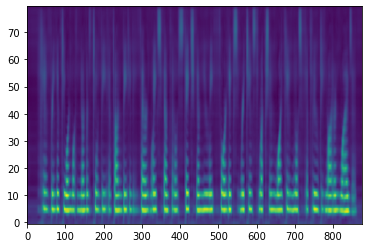

In [10]:
def infer(spec_gen_model, vocoder_model, str_input, speaker = None):
    """
    Synthesizes spectrogram and audio from a text string given a spectrogram synthesis and vocoder model.
    
    Arguments:
    spec_gen_model -- Instance of FastPitch model
    vocoder_model -- Instance of a vocoder model (HiFiGAN in our case)
    str_input -- Text input for the synthesis
    speaker -- Speaker number (in the case of a multi-speaker model -- in the mixing case)
    
    Returns:
    spectrogram, waveform of the synthesized audio.
    """
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        if speaker is not None:
            speaker = torch.tensor([speaker]).long().cuda()
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, speaker = speaker)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)
        
    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

imshow(infer(spec_gen, vocoder, 'with the reduction of numbers to be accommodated, there was ample space in newgate for its reconstruction on the most approved modern lines.')[0], origin="lower", aspect = "auto")

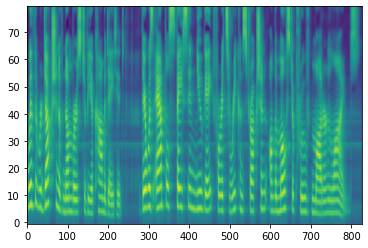

In [11]:
imshow(infer(spec_gen, vocoder, 'with the reduction of numbers to be accommodated, there was ample space in newgate for its reconstruction on the most approved modern lines.')[0], origin="lower", aspect = "auto")

In [38]:
mels_pred

tensor([[[-1.4040, -1.5973, -1.5042,  ..., -1.9274, -1.8231, -1.8963],
         [-1.6984, -2.1206, -1.9091,  ..., -1.9824, -1.9668, -1.7048],
         [-0.6311, -0.9111, -0.6124,  ..., -0.9617, -0.6592, -0.5671],
         ...,
         [-1.5024, -1.4428, -1.2400,  ..., -1.3411, -1.3336, -1.4258],
         [-0.5703, -0.5187, -0.6938,  ..., -0.2374, -0.3465,  0.1954],
         [-1.6109, -1.3275, -1.6824,  ..., -1.3092, -1.3722, -1.2248]]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

In [ ]:
# for batch_idx, batch in enumerate(UnpairedAudioToBPEDataset(manifest_filepath="../../datasets/LJSpeech-1.1/small_manifest.json",
#                     unpaired_text_manifest_filepath="../../datasets/LJSpeech-1.1/train_manifest_text.json",
#                     unpaired_signal_manifest_filepath="../../datasets/LJSpeech-1.1/train_manifest_signal.json",                   
#                     tokenizer=asr_model.tokenizer,
#                     sample_rate=22050)):    
    
#     signal, signal_len, transcript, transcript_len, raw_signal, raw_signal_len, raw_text, raw_text_len = batch
# #     signal, signal_len, transcript, transcript_len = signal.cuda(), signal_len.cuda(), \
# #         transcript.cuda(), transcript_len.cuda()
#     print(raw_text)
    
#     break

In [34]:
config_path = 'stt_en_citrinet_256_gamma_0_25'
config_name = 'model_config.yaml'
yaml = YAML(typ='safe')

with open(os.path.join(config_path, config_name)) as f:
    config = yaml.load(f)

config['tokenizer']['dir'] = 'citrinet_tokenizer/tokenizer_spe_unigram_v1024'
config['tokenizer']['type'] = 'bpe'

config['train_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/small_manifest.json"
# config['train_ds']['manifest_filepath']="../../datasets/an4/train_manifest.json"
config['train_ds']['batch_size'] = 1
config['train_ds']['num_workers'] = 12
config['train_ds']['pin_memory'] = True

config['validation_ds']['manifest_filepath']="../../datasets/LJSpeech-1.1/small_manifest.json"
# config['validation_ds']['manifest_filepath']="../../datasets/an4/test_manifest.json"
config['validation_ds']['batch_size'] = 1
config['validation_ds']['num_workers'] = 12
config['validation_ds']['pin_memory'] = True

config['spec_augment']['freq_masks'] = 0
config['spec_augment']['time_masks'] = 0
config['optim']['lr'] = 1e-1
config['optim']['name'] = 'novograd'
config['optim']['betas'] = [0.8, 0.25]
config['optim']['weight_decay'] = 0.001
config['optim']['sched']['warmup_steps']=1000
config['optim']['sched']['min_lr'] = 0.00001

config['tokenizer']['model_path'] = 'stt_en_citrinet_256_gamma_0_25/3d20ebb793c84a64a20c7ad26fc64d62_tokenizer.model'
config['tokenizer']['vocab_path'] = 'stt_en_citrinet_256_gamma_0_25/df5191f216004f10a268c44e90fdb63f_vocab.txt'
config['tokenizer']['spe_tokenizer_vocab'] = 'stt_en_citrinet_256_gamma_0_25/b774eaac83804907843607272fde21a4_tokenizer.vocab'

asr_model = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(config))

# asr_model.setup_optimization()

In [35]:
trainer = pl.Trainer(max_epochs=10, gpus=1)

trainer.fit(asr_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConvASREncoder                    | 9.1 M 
2 | decoder           | ConvASRDecoder                    | 657 K 
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WERBPE                            | 0     
------------------------------------------------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.145    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [29]:
def val():
    torch.set_grad_enabled(False)
    asr_model.on_validation_start()
    asr_model.on_epoch_start()
    asr_model.on_validation_epoch_start()

    val_outs = []

    for batch_idx, val_batch in enumerate(asr_model.val_dataloader()):

        asr_model.on_validation_batch_start(val_batch, batch_idx, dataloader_idx)

        batch = asr_model.on_before_batch_transfer(val_batch, dataloader_idx)
        batch = asr_model.transfer_batch_to_device(batch, torch.device('cuda'), dataloader_idx)
        batch = asr_model.on_after_batch_transfer(batch, dataloader_idx)

        out = asr_model.cuda().validation_step(batch, batch_idx)

        val_loss, val_wer_num, val_wer_denom, val_wer = out
        
        asr_model.on_validation_batch_end(out, batch, batch_idx, dataloader_idx)
        val_outs.append(out)
        
    asr_model.on_epoch_end()
    asr_model.on_validation_end()

    torch.set_grad_enabled(True)
    
    return val_outs

In [ ]:
val_outs = val()

In [ ]:
val_wer = []
for item in val_outs:
    val_wer.append(item['val_wer'])
    
print(torch.mean(torch.tensor(val_wer)))

In [ ]:
# tensor(0.9326)

In [ ]:
asr_model.transcribe(["../../datasets//LJSpeech-1.1/wavs/LJ015-0247.wav",
                     "../../datasets//LJSpeech-1.1/wavs/LJ028-0475.wav",
                     "../../datasets//LJSpeech-1.1/wavs/LJ013-0049.wav"])

In [8]:
def fastpitch_training_step(self, audio, audio_lens, text, text_lens, durs, pitch, batch_idx=1):
    mels, spec_len = self.preprocessor(input_signal=audio, length=audio_lens)

    mels_pred, _, _, log_durs_pred, pitch_pred, attn_soft, attn_logprob, attn_hard, attn_hard_dur, pitch = self(
        text=text,
        durs=durs,
        pitch=pitch,
        speaker=None,
        pace=1.0,
        spec=mels if self.learn_alignment else None,
        attn_prior=None,
        mel_lens=spec_len,
        input_lens=text_lens,
    )
    if durs is None:
        durs = attn_hard_dur

    mel_loss = self.mel_loss(spect_predicted=mels_pred, spect_tgt=mels)
    dur_loss = self.duration_loss(log_durs_predicted=log_durs_pred, durs_tgt=durs, len=text_lens)
    loss = mel_loss + dur_loss

    pitch_loss = self.pitch_loss(pitch_predicted=pitch_pred, pitch_tgt=pitch, len=text_lens)
    loss += pitch_loss

    return loss

def hifigan_training_step(self, batch, batch_idx, optimizer_idx):
    # if in finetune mode the mels are pre-computed using a
    # spectrogram generator
    if self.input_as_mel:
        audio, audio_len, audio_mel = batch
    # else, we compute the mel using the ground truth audio
    else:
        audio, audio_len = batch
        # mel as input for generator
        audio_mel, _ = self.audio_to_melspec_precessor(audio, audio_len)

    # mel as input for L1 mel loss
    audio_trg_mel, _ = self.trg_melspec_fn(audio, audio_len)
    audio = audio.unsqueeze(1)

    audio_pred = self.generator(x=audio_mel)
    audio_pred_mel, _ = self.trg_melspec_fn(audio_pred.squeeze(1), audio_len)

    # train discriminator
#     self.optim_d.zero_grad()
    mpd_score_real, mpd_score_gen, _, _ = self.mpd(y=audio, y_hat=audio_pred.detach())
    loss_disc_mpd, _, _ = self.discriminator_loss(
        disc_real_outputs=mpd_score_real, disc_generated_outputs=mpd_score_gen
    )
    msd_score_real, msd_score_gen, _, _ = self.msd(y=audio, y_hat=audio_pred.detach())
    loss_disc_msd, _, _ = self.discriminator_loss(
        disc_real_outputs=msd_score_real, disc_generated_outputs=msd_score_gen
    )
    loss_d = loss_disc_msd + loss_disc_mpd
    
    return loss_d
#     self.manual_backward(loss_d)
#     self.optim_d.step()

#     # train generator
#     self.optim_g.zero_grad()
#     loss_mel = F.l1_loss(audio_pred_mel, audio_trg_mel)
#     _, mpd_score_gen, fmap_mpd_real, fmap_mpd_gen = self.mpd(y=audio, y_hat=audio_pred)
#     _, msd_score_gen, fmap_msd_real, fmap_msd_gen = self.msd(y=audio, y_hat=audio_pred)
#     loss_fm_mpd = self.feature_loss(fmap_r=fmap_mpd_real, fmap_g=fmap_mpd_gen)
#     loss_fm_msd = self.feature_loss(fmap_r=fmap_msd_real, fmap_g=fmap_msd_gen)
#     loss_gen_mpd, _ = self.generator_loss(disc_outputs=mpd_score_gen)
#     loss_gen_msd, _ = self.generator_loss(disc_outputs=msd_score_gen)
#     loss_g = loss_gen_msd + loss_gen_mpd + loss_fm_msd + loss_fm_mpd + loss_mel * self.l1_factor
#     self.manual_backward(loss_g)
#     self.optim_g.step()

def citrinet_training_step(self, batch, batch_nb):
    signal, signal_len, transcript, transcript_len = batch
    
    log_probs, encoded_len, predictions = self.forward(input_signal=signal, input_signal_length=signal_len)

    loss_value = self.loss(
        log_probs=log_probs, targets=transcript, input_lengths=encoded_len, target_lengths=transcript_len
    )

    return loss_value

# for batch in asr_model.test_dataloader():
#     signal, signal_len, transcript, transcript_len = batch
        
#     target = asr_model._wer.ctc_decoder_predictions_tensor(
#         transcript, predictions_len=transcript_len, return_hypotheses=False,
#     )
    
#     parsed = fastpitch.parse(target[0])
    
#     spec, _, durs_pred, _, pitch_pred, *_ = fastpitch.eval()(text=parsed,
#                                                              durs=None, pitch=None, speaker=None, pace=1.0)
        
#     loss = fastpitch_training_step(fastpitch.cpu().train(), signal, signal_len, parsed,
#                                    torch.tensor([len(parsed)]), durs_pred, pitch_pred, batch_idx=1).cpu()
    
#     hifigan.input_as_mel = True
#     loss_2 = hifigan_training_step(hifigan.cpu().train(), batch=[signal, signal_len, spec], batch_idx=1, optimizer_idx=1)
    
#     loss_asr = citrinet_training_step(asr_model.cpu().train(), batch=batch, batch_nb=1)
    
#     print(loss, loss_2, loss_asr)
#     break

In [98]:
# # Dual Transformation: text -> predicted_speech -> predicted_text -> loss
# def dt_text_training_step(batch, batch_idx, optimizer_idx=None):
#     if optimizer_idx is None:
#         optimizer_idx = batch_idx
    
#     _, _, transcript, transcript_len = batch
        
#     target = asr_model._wer.ctc_decoder_predictions_tensor(
#         transcript, predictions_len=transcript_len, return_hypotheses=False,
#     )
    
#     parsed = fastpitch.parse(target[0]).cpu()
    
#     spec, _, durs_pred, _, pitch_pred, *_ = fastpitch.cpu().eval()(text=parsed,
#                                                              durs=None, pitch=None, speaker=None, pace=1.0)
        
#     fastpitch.eval()(text=parsed, durs=durs_pred, pitch=pitch_pred, speaker=None, pace=1.0)
    
#     signal = hifigan.cpu().eval().convert_spectrogram_to_audio(spec=spec).to('cpu')
#     signal_len = torch.tensor([len(signal[0])])
        
#     loss = citrinet_training_step(asr_model.cpu().train(),
#                                   batch=[signal, signal_len, transcript, transcript_len], batch_nb=batch_idx)

#     fastpitch_training_step(fastpitch.cpu().train(), signal, signal_len, parsed,
#                                    torch.tensor([len(parsed)]), durs_pred, pitch_pred, batch_idx=batch_idx).cpu()

#     hifigan.input_as_mel = True
#     hifigan_training_step(hifigan.cpu().train(),
#                                    batch=[signal, signal_len, spec], batch_idx=batch_idx, optimizer_idx=optimizer_idx)
    
#     return loss

In [94]:
# # Dual Transformation: speech -> predicted_text -> predicted_speech -> loss
# def dt_speech_training_step(batch, batch_idx, optimizer_idx=None):
#     if optimizer_idx is None:
#         optimizer_idx = batch_idx
        
#     signal, signal_len, _, _ = batch

#     logits, logits_len, greedy_predictions = asr_model.eval().cpu()(input_signal=signal,
#                                                                     input_signal_length=signal_len)
#     current_hypotheses = asr_model._wer.ctc_decoder_predictions_tensor(
#         greedy_predictions, predictions_len=logits_len
#     )
    
#     transcript = fastpitch.parse(current_hypotheses[0])
#     transcript_len = torch.tensor([len(transcript[0])]) 
        
#     spec, _, durs_pred, _, pitch_pred, *_ = fastpitch.eval()(text=transcript, durs=None, pitch=None, speaker=None, pace=1.0)
#     gt = train_batch[0]
# #     pred = hifigan.cpu().eval().convert_spectrogram_to_audio(spec=spec.cpu()).to('cpu')
                 
# #     citrinet_training_step(asr_model.cpu().train(),
# #                                   batch=[signal, signal_len, transcript, transcript_len], batch_nb=batch_idx)

# #     fastpitch_training_step(fastpitch.cpu().train(), signal, signal_len, transcript,
# #                                    transcript_len.cpu(), durs_pred, pitch_pred, batch_idx=batch_idx).cpu()

# #     hifigan.input_as_mel = True
# #     hifigan_training_step(hifigan.cpu().train(),
# #                                    batch=[signal, signal_len, spec], batch_idx=batch_idx, optimizer_idx=optimizer_idx)    
    
# #     return ((signal[0][:min(len(signal[0]), len(pred[0]))] - 
# #              pred[0][:min(len(signal[0]), len(pred[0]))].detach().numpy()) ** 2).sum()
    

In [24]:
# for step, train_batch in enumerate(asr_model.train_dataloader()):
#     loss = 0
    
#     loss += dt_text_training_step(train_batch, step)
# #     loss += dt_text_training_step(flip_batch(train_batch), step)
    
# #     loss += dt_speech_training_step(train_batch, step)
# #     loss += dt_text_training_step(flip_batch(train_batch), step)
    
#     ###
#     # Add loss for paired data
#     ###

#     ###
#     # Add loss for Denoising Auto-Encoder
#     ###

#     # print(step, loss)
    